In [307]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    make_scorer, average_precision_score, roc_auc_score, precision_score, 
    recall_score, f1_score, roc_curve, precision_recall_curve, auc, confusion_matrix
)
from imblearn.metrics import specificity_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from tqdm import tqdm
import shap

In [277]:
df= pd.read_csv('/Users/ormeiri/Desktop/predictive_models_git/data/training_v2.csv')
df

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.730000,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.420000,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.950000,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.640000,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,91592,78108,30,0,75.0,23.060250,0,Caucasian,M,177.8,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Sepsis,Cardiovascular
91709,66119,13486,121,0,56.0,47.179671,0,Caucasian,F,183.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
91710,8981,58179,195,0,48.0,27.236914,0,Caucasian,M,170.2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
91711,33776,120598,66,0,NaN,23.297481,0,Caucasian,F,154.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory


In [278]:
# List of APACHE features to keep
apache_keep = [
    "apache_3j_bodysystem",
    "apache_2_bodysystem",
    "apache_2_diagnosis",
    "apache_3j_diagnosis",
    "gcs_eyes_apache",
    "gcs_motor_apache",
    "gcs_verbal_apache",
    "gcs_unable_apache",
    "apache_post_operative",
    "arf_apache",
]

# Drop all other apache-related columns
apache_cols = [col for col in df.columns if "apache" in col]
apache_to_drop = [col for col in apache_cols if col not in apache_keep]
apache_to_drop.append("elective_surgery")  # Drop elective_surgery as well
df = df.drop(columns=apache_to_drop)

In [279]:
target_column = "hospital_death"
# Original dataset preprocessing (with all features)
X_original = df.drop(columns=[target_column, "patient_id", "encounter_id"])
y = df[target_column]

## Feature Selection

In [280]:
# Function to apply the feature selection techniques from the paper
def apply_feature_selection(df, target_column="hospital_death"):
    """
    Apply the feature selection methods described in the Cohen et al. paper:
    1. Drop features with high percentage of missing values (>80%)
    2. Remove collinear features (>0.99)
    3. Drop features with zero standard deviation
    4. Drop features with high RFE ranking
    5. Drop features with different distributions between train/test sets
    6. Drop overly aggressive features (APACHE scores)
    
    Returns:
        selected_features: List of features after selection
        dropped_features: List of dropped features with reasons
    """
    print("Starting feature selection process...")
    
    # Create a copy of the dataframe
    # X = df.drop(columns=[target_column, "patient_id", "encounter_id"])
    X = df.drop(columns=["patient_id", "encounter_id"])
    y = df[target_column]
    
    # Split for adversarial validation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    dropped_features = {}
    original_feature_count = X.shape[1]
    
    # 1. Drop features with high percentage of missing values (>80%)
    missing_rates = X.isnull().mean()
    high_missing_features = missing_rates[missing_rates > 0.8].index.tolist()
    dropped_features["high_missing_values"] = high_missing_features
    X = X.drop(columns=high_missing_features)
    print(f"Dropped {len(high_missing_features)} features with >80% missing values")
    
    # 2. Find and remove collinear features (>0.99) - only among numeric columns
    numeric_cols = X.select_dtypes(include=['number']).columns
    # Only calculate correlation if we have sufficient numeric columns
    collinear_features = []
    if len(numeric_cols) > 1:  # Need at least 2 columns to check for collinearity
        # Fill missing values temporarily for correlation calculation
        X_numeric_filled = X[numeric_cols].fillna(X[numeric_cols].mean())
        corr_matrix = X_numeric_filled.corr().abs()
        
        # Remove collinear features more selectively
        collinear_features = []
        upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        
        # Sort pairs by correlation for deterministic selection
        collinear_pairs = []
        for col in upper_tri.columns:
            for idx, val in upper_tri[col].items():
                if val > 0.99:
                    collinear_pairs.append((idx, col, val))
        
        # Sort by correlation value (highest first)
        collinear_pairs.sort(key=lambda x: x[2], reverse=True)
        
        # Keep track of columns already marked for removal
        already_removed = set()
        to_keep = set()
        # Process pairs and mark one column to remove from each pair
        for col1, col2, corr_val in collinear_pairs:
            # Skip if both columns are already in the removal list
            if col1 in already_removed and col2 in already_removed:
                continue
            
            # Choose which one to remove (e.g., by missing values or variance)
            # Here we simply keep the first alphabetically
            if col1 not in already_removed and col2 not in already_removed:
                to_remove = col2 if col1 < col2 else col1
                to_keep.add(col1 if col1 < col2 else col2)
                already_removed.add(to_remove)
                collinear_features.append(to_remove)
        
    
    dropped_features["collinear_features"] = collinear_features
    X = X.drop(columns=collinear_features)
    print(f"Dropped {len(collinear_features)} collinear features")
    
    # 3. Drop features with zero standard deviation (numeric columns) or single unique value (categorical columns)
    # Handle numeric columns
    numeric_cols = X.select_dtypes(include=['number']).columns
    zero_std_features = numeric_cols[X[numeric_cols].std() == 0].tolist()
    
    # Handle categorical columns with only one unique value
    categorical_cols = X.select_dtypes(exclude=['number']).columns
    single_value_categorical = []
    for col in categorical_cols:
        unique_values = X[col].dropna().unique()
        if len(unique_values) <= 1:
            single_value_categorical.append(col)
    
    # Combine both sets of features to drop
    zero_variance_features = zero_std_features + single_value_categorical
    dropped_features["zero_variance_features"] = zero_variance_features
    X = X.drop(columns=zero_variance_features)
    
    print(f"Dropped {len(zero_std_features)} numeric features with zero standard deviation")
    print(f"Dropped {len(single_value_categorical)} categorical features with only one unique value")
    
    # Final list of selected features
    selected_features = X.columns.tolist()
    print(f"Feature selection complete. Kept {len(selected_features)} features out of {original_feature_count}")
    
    return selected_features, dropped_features

In [281]:
# create dataframe with selected features
selected_features, dropped_features = apply_feature_selection(df, target_column)
X_selected = df[selected_features]

Starting feature selection process...
Dropped 34 features with >80% missing values
Dropped 7 collinear features
Dropped 1 numeric features with zero standard deviation
Dropped 0 categorical features with only one unique value
Feature selection complete. Kept 119 features out of 161


In [282]:
X_selected

,hospital_id,hospital_death,age,bmi,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,118,0,68.0,22.730000,Caucasian,M,180.3,Floor,Floor,92,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,81,0,77.0,27.420000,Caucasian,F,160.0,Floor,Floor,90,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,118,0,25.0,31.950000,Caucasian,F,172.7,Emergency Department,Accident & Emergency,93,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,118,0,81.0,22.640000,Caucasian,F,165.1,Operating Room,Operating Room / Recovery,92,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,33,0,19.0,NaN,Caucasian,M,188.0,NaN,Accident & Emergency,91,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,30,0,75.0,23.060250,Caucasian,M,177.8,Acute Care/Floor,Floor,927,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Sepsis,Cardiovascular
91709,121,0,56.0,47.179671,Caucasian,F,183.0,Emergency Department,Floor,925,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
91710,195,0,48.0,27.236914,Caucasian,M,170.2,Emergency Department,Accident & Emergency,908,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
91711,66,0,NaN,23.297481,Caucasian,F,154.9,Emergency Department,Accident & Emergency,922,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory


In [283]:
X_selected.columns

Index(['hospital_id', 'hospital_death', 'age', 'bmi', 'ethnicity', 'gender',
       'height', 'hospital_admit_source', 'icu_admit_source', 'icu_id',
       ...
       'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure',
       'immunosuppression', 'leukemia', 'lymphoma',
       'solid_tumor_with_metastasis', 'apache_3j_bodysystem',
       'apache_2_bodysystem'],
      dtype='object', length=119)

In [284]:
# Preprocess data
numeric_cols = X_selected.select_dtypes(include=['number'])
numeric_cols = numeric_cols.drop(columns=['hospital_id', 'hospital_death', 'icu_id', 'apache_post_operative']).columns
categorical_cols = X_selected.select_dtypes(exclude=['number']).columns

# Impute missing values
imputer = SimpleImputer(strategy="mean")
cat_imputer = SimpleImputer(strategy='most_frequent')

X_num = pd.DataFrame(imputer.fit_transform(X_selected[numeric_cols]), 
                    columns=numeric_cols, 
                    index=X_selected.index)
X_cat = pd.DataFrame(cat_imputer.fit_transform(X_selected[categorical_cols]), 
                    columns=categorical_cols,
                    index=X_selected.index)

# Scale numeric columns
scaler = StandardScaler()
X_num_scaled = pd.DataFrame(scaler.fit_transform(X_num), 
                           columns=numeric_cols, 
                           index=X_selected.index)

# Encode categorical features
X_cat_encoded = pd.get_dummies(X_cat, drop_first=True)

X_no_preprocessed = X_selected[["apache_post_operative", "hospital_death"]]

# Combine numeric and categorical
processed_data = pd.concat([X_num_scaled, X_cat_encoded, X_no_preprocessed], axis=1)
processed_data

,age,bmi,height,pre_icu_los_days,weight,apache_2_diagnosis,apache_3j_diagnosis,arf_apache,gcs_eyes_apache,gcs_motor_apache,...,apache_2_bodysystem_Haematologic,apache_2_bodysystem_Metabolic,apache_2_bodysystem_Neurologic,apache_2_bodysystem_Renal/Genitourinary,apache_2_bodysystem_Respiratory,apache_2_bodysystem_Trauma,apache_2_bodysystem_Undefined Diagnoses,apache_2_bodysystem_Undefined diagnoses,apache_post_operative,hospital_death
0,3.473240e-01,-7.951567e-01,0.994578,-0.118219,-4.110915e-01,-0.849116,-0.122062,-0.170324,-0.493791,4.147661e-01,...,False,False,False,False,False,False,False,False,0,0
1,8.966473e-01,-2.174940e-01,-0.899694,0.036986,-5.612680e-01,-0.907756,-0.771391,-0.170324,-2.617396,-1.938273e+00,...,False,False,False,False,True,False,False,False,0,0
2,-2.277221e+00,3.404616e-01,0.285392,-0.335674,4.574969e-01,-0.743566,0.314487,-0.170324,-0.493791,4.147661e-01,...,False,True,False,False,False,False,False,False,0,0
3,1.140791e+00,-8.062419e-01,-0.423793,-0.335674,-9.062681e-01,0.206390,1.406837,-0.170324,0.568012,4.147661e-01,...,False,False,False,False,False,False,False,False,1,0
4,-2.643436e+00,4.375842e-16,1.713095,-0.306364,5.767937e-16,-0.778749,0.092934,-0.170324,0.000000,-6.966396e-16,...,False,False,False,False,False,True,False,False,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,7.745754e-01,-7.544801e-01,0.761293,-0.215921,-4.516798e-01,-0.849116,-0.124125,-0.170324,0.568012,4.147661e-01,...,False,False,False,False,False,False,False,False,0,0
91709,-3.851071e-01,2.216285e+00,1.246525,-0.287661,3.002380e+00,-0.849116,-0.124146,-0.170324,0.568012,4.147661e-01,...,False,False,False,False,False,False,False,False,0,0
91710,-8.733945e-01,-2.400446e-01,0.052108,-0.317251,-2.081503e-01,-0.731838,0.312272,-0.170324,-0.493791,4.147661e-01,...,False,True,False,False,False,False,False,False,0,0
91711,-8.673727e-16,-7.252605e-01,-1.375595,-0.303014,-1.141680e+00,-0.907756,-0.771391,-0.170324,0.568012,-3.695805e-01,...,False,False,False,False,True,False,False,False,0,0


In [285]:
train_data, test_data = train_test_split(processed_data, test_size=0.2, random_state=42, stratify=processed_data[target_column])

# Model Training and Evaluation

In [321]:
train_data.to_csv('/Users/ormeiri/Desktop/predictive_models_git/data/train_test_split/train_preprocessed_data.csv', index=False)
test_data.to_csv('/Users/ormeiri/Desktop/predictive_models_git/data/train_test_split/test_preprocessed_data.csv', index=False)

In [322]:
target_column = "hospital_death"

# 2. Split the training data into training and validation sets
X_train_full = train_data.drop(columns=[target_column])
y_train_full = train_data[target_column]
X_test = test_data.drop(columns=[target_column])
y_test = test_data[target_column]

In [323]:
# Split the training data into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_train_full
)

In [324]:
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# 3. Define models and parameter grids
param_grids = {
    "Logistic Regression": {
        'C': [0.01, 0.1, 1.0, 10.0],
        'penalty': ['l2'],
    },
    "XGBoost": {
        'learning_rate': [0.01, 0.05, 0.1, 0.3],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
        'gamma': [0, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    },
    "KNN": {
        'n_neighbors': [3, 5, 7, 11, 15, 21],
        'weights': ['uniform', 'distance'],
        'p': [1, 2],
    }
}

# Initialize base models
base_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42),
    "KNN": KNeighborsClassifier()
}

Training set size: 58696
Validation set size: 14674
Test set size: 18343


In [325]:
# 4. Hyperparameter tuning with grid search on train/validation
best_models = {}
best_scores = {}

for name, model in base_models.items():
    print(f"\nGrid searching for best parameters for {name}...")
    
    # Use GridSearchCV with 5-fold cross-validation on the training set
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        scoring='average_precision',
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    
    # Fit grid search
    grid.fit(X_train, y_train)
    
    # Get best model
    best_model = grid.best_estimator_
    best_models[name] = best_model
    
    # Evaluate on validation set
    y_val_pred = best_model.predict(X_val)
    y_val_prob = best_model.predict_proba(X_val)[:, 1]
    
    val_precision = precision_score(y_val, y_val_pred)
    val_recall = recall_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred)
    val_pr_auc = average_precision_score(y_val, y_val_prob)
    val_roc_auc = roc_auc_score(y_val, y_val_prob)
    val_specificity = specificity_score(y_val, y_val_pred)
    
    best_scores[name] = {
        "Best Parameters": grid.best_params_,
        "CV Score": grid.best_score_,
        "Validation Precision": val_precision,
        "Validation Recall": val_recall,
        "Validation F1": val_f1,
        "Validation PR AUC": val_pr_auc,
        "Validation ROC AUC": val_roc_auc,
        "Validation Specificity": val_specificity
    }
    
    print(f"Best parameters for {name}: {grid.best_params_}")
    print(f"Best CV score: {grid.best_score_:.4f}")
    print(f"Validation ROC AUC: {val_roc_auc:.4f}, PR AUC: {val_pr_auc:.4f}")

# 5. Display results from validation
print("\nValidation Results:")
for name, scores in best_scores.items():
    print(f"\n{name}:")
    print(f"  Precision: {scores['Validation Precision']:.4f}")
    print(f"  Recall: {scores['Validation Recall']:.4f}")
    print(f"  F1: {scores['Validation F1']:.4f}")
    print(f"  PR AUC: {scores['Validation PR AUC']:.4f}")
    print(f"  ROC AUC: {scores['Validation ROC AUC']:.4f}")
    print(f"  Specificity: {scores['Validation Specificity']:.4f}")

# Identify the best model based on validation PR AUC
best_model_name = max(best_scores, key=lambda x: best_scores[x]["Validation PR AUC"])
print(f"\nBest model based on validation PR AUC: {best_model_name}")


Grid searching for best parameters for Logistic Regression...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for Logistic Regression: {'C': 0.1, 'penalty': 'l2'}
Best CV score: 0.4928
Validation ROC AUC: 0.8796, PR AUC: 0.5208

Grid searching for best parameters for XGBoost...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters for XGBoost: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.8}
Best CV score: 0.5540
Validation ROC AUC: 0.9033, PR AUC: 0.5756

Grid searching for best parameters for KNN...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters for KNN: {'n_neighbors': 21, 'p': 1, 'weights': 'distance'}
Best CV score: 0.4222
Validation ROC AUC: 0.8051, PR AUC: 0.4444

Validation Results:

Logistic Regression:
  Precision: 0.7276
  Recall: 0.2828
  F1: 0.4073
  PR AUC: 0.5208
  ROC AUC: 0.8796
  Specificity: 0.9900

XGBoost:
  Pre

In [319]:
knn_model = joblib.load('models/knn_best_model.joblib')
lr_model = joblib.load('models/logistic_regression_best_model.joblib')
xgb_model = joblib.load('models/xgboost_best_model.joblib')

In [326]:
# 6. Bootstrap evaluation on the test set for ALL models
n_bootstraps = 1000
bootstrap_results = {}

for model_name, model in best_models.items():
    print(f"\nPerforming bootstrap evaluation for {model_name}...")
    
    # Predict on test set
    y_test_prob = model.predict_proba(X_test)[:, 1]
    
    # Initialize metrics for this model
    metrics = {
        'Precision': [],
        'Recall': [],
        'F1': [],
        'PR AUC': [],
        'ROC AUC': [],
        'Specificity': []
    }
    
    # Run bootstrap
    for i in tqdm(range(n_bootstraps)):
        # Resample with replacement
        indices = np.random.choice(len(y_test), len(y_test), replace=True)
        y_true_bootstrap = y_test.iloc[indices].values if isinstance(y_test, pd.Series) else y_test[indices]
        y_prob_bootstrap = y_test_prob[indices]
        
        # Set a threshold of 0.5 for binary predictions
        y_pred_bootstrap = (y_prob_bootstrap >= 0.5).astype(int)
        
        # Calculate metrics
        try:
            metrics['Precision'].append(precision_score(y_true_bootstrap, y_pred_bootstrap))
            metrics['Recall'].append(recall_score(y_true_bootstrap, y_pred_bootstrap))
            metrics['F1'].append(f1_score(y_true_bootstrap, y_pred_bootstrap))
            metrics['PR AUC'].append(average_precision_score(y_true_bootstrap, y_prob_bootstrap))
            metrics['ROC AUC'].append(roc_auc_score(y_true_bootstrap, y_prob_bootstrap))
            metrics['Specificity'].append(specificity_score(y_true_bootstrap, y_pred_bootstrap))
        except:
            # Skip if there's an issue with the bootstrap sample
            continue
    
    # Calculate bootstrap statistics for this model
    model_results = {}
    for metric, values in metrics.items():
        mean_value = np.mean(values)
        lower_bound = np.percentile(values, 2.5)
        upper_bound = np.percentile(values, 97.5)
        
        model_results[metric] = {
            'Mean': mean_value,
            'Lower Bound (2.5%)': lower_bound,
            'Upper Bound (97.5%)': upper_bound,
            'Margin': (upper_bound - lower_bound) / 2
        }
    
    bootstrap_results[model_name] = model_results
    
    # Print bootstrap results for this model
    print(f"\nBootstrap Results for {model_name}:")
    for metric, stats in model_results.items():
        print(f"{metric}: {stats['Mean']:.4f} ± {stats['Margin']:.4f} [95% CI: {stats['Lower Bound (2.5%)']: .4f} - {stats['Upper Bound (97.5%)']: .4f}]")


Performing bootstrap evaluation for Logistic Regression...


100%|██████████| 1000/1000 [00:13<00:00, 73.77it/s]



Bootstrap Results for Logistic Regression:
Precision: 0.6969 ± 0.0364 [95% CI:  0.6610 -  0.7337]
Recall: 0.2878 ± 0.0227 [95% CI:  0.2648 -  0.3102]
F1: 0.4073 ± 0.0266 [95% CI:  0.3797 -  0.4330]
PR AUC: 0.5224 ± 0.0251 [95% CI:  0.4969 -  0.5471]
ROC AUC: 0.8829 ± 0.0084 [95% CI:  0.8747 -  0.8916]
Specificity: 0.9882 ± 0.0017 [95% CI:  0.9865 -  0.9898]

Performing bootstrap evaluation for XGBoost...


100%|██████████| 1000/1000 [00:12<00:00, 79.40it/s]



Bootstrap Results for XGBoost:
Precision: 0.7215 ± 0.0307 [95% CI:  0.6907 -  0.7520]
Recall: 0.3395 ± 0.0231 [95% CI:  0.3167 -  0.3630]
F1: 0.4616 ± 0.0249 [95% CI:  0.4367 -  0.4865]
PR AUC: 0.5840 ± 0.0232 [95% CI:  0.5604 -  0.6067]
ROC AUC: 0.9041 ± 0.0073 [95% CI:  0.8968 -  0.9114]
Specificity: 0.9876 ± 0.0017 [95% CI:  0.9859 -  0.9894]

Performing bootstrap evaluation for KNN...


100%|██████████| 1000/1000 [00:12<00:00, 80.83it/s]


Bootstrap Results for KNN:
Precision: 0.9391 ± 0.0381 [95% CI:  0.8974 -  0.9737]
Recall: 0.0974 ± 0.0146 [95% CI:  0.0828 -  0.1119]
F1: 0.1764 ± 0.0239 [95% CI:  0.1520 -  0.1999]
PR AUC: 0.4589 ± 0.0254 [95% CI:  0.4330 -  0.4837]
ROC AUC: 0.7996 ± 0.0127 [95% CI:  0.7867 -  0.8121]
Specificity: 0.9994 ± 0.0004 [95% CI:  0.9990 -  0.9998]


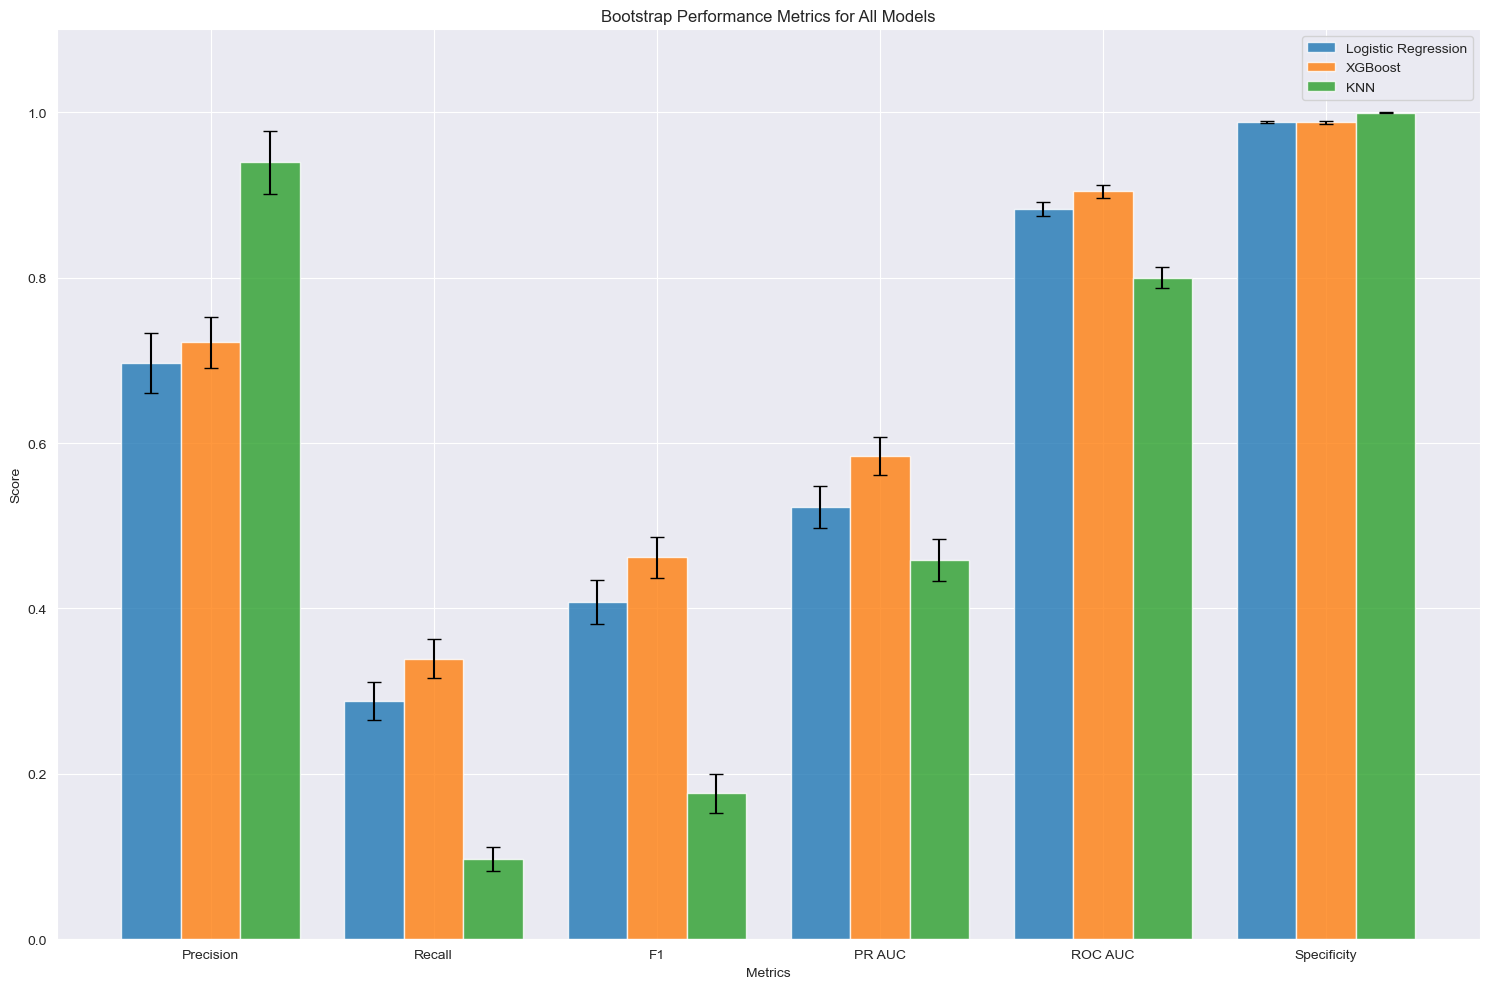

In [327]:
# 7. Visualize bootstrap results for all models
# Create a grouped bar plot for all metrics across all models
metrics_to_plot = ['Precision', 'Recall', 'F1', 'PR AUC', 'ROC AUC', 'Specificity']
model_names = list(bootstrap_results.keys())
num_metrics = len(metrics_to_plot)
num_models = len(model_names)

# Set up the figure
plt.figure(figsize=(15, 10))
bar_width = 0.8 / num_models
opacity = 0.8

# Plot bars for each model and metric
for i, model_name in enumerate(model_names):
    means = [bootstrap_results[model_name][metric]['Mean'] for metric in metrics_to_plot]
    errors = [bootstrap_results[model_name][metric]['Margin'] for metric in metrics_to_plot]
    
    x_pos = np.arange(num_metrics) + i * bar_width - (num_models - 1) * bar_width / 2
    
    plt.bar(x_pos, means, bar_width, alpha=opacity, label=model_name,
            yerr=errors, capsize=5)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Bootstrap Performance Metrics for All Models')
plt.xticks(np.arange(num_metrics), metrics_to_plot)
plt.ylim(0, 1.1)
plt.legend()
plt.tight_layout()
plt.savefig('all_models_bootstrap_metrics.png', dpi=300)
plt.show()


Detailed Comparison Table:
                     Precision Mean  Precision Margin  Recall Mean  \
Logistic Regression          0.6969            0.0364       0.2878   
XGBoost                      0.7215            0.0307       0.3395   
KNN                          0.9391            0.0381       0.0974   

                     Recall Margin  F1 Mean  F1 Margin  PR AUC Mean  \
Logistic Regression         0.0227   0.4073     0.0266       0.5224   
XGBoost                     0.0231   0.4616     0.0249       0.5840   
KNN                         0.0146   0.1764     0.0239       0.4589   

                     PR AUC Margin  ROC AUC Mean  ROC AUC Margin  \
Logistic Regression         0.0251        0.8829          0.0084   
XGBoost                     0.0232        0.9041          0.0073   
KNN                         0.0254        0.7996          0.0127   

                     Specificity Mean  Specificity Margin  
Logistic Regression            0.9882              0.0017  
XGBoost      

100%|██████████| 100/100 [00:01<00:00, 93.80it/s]


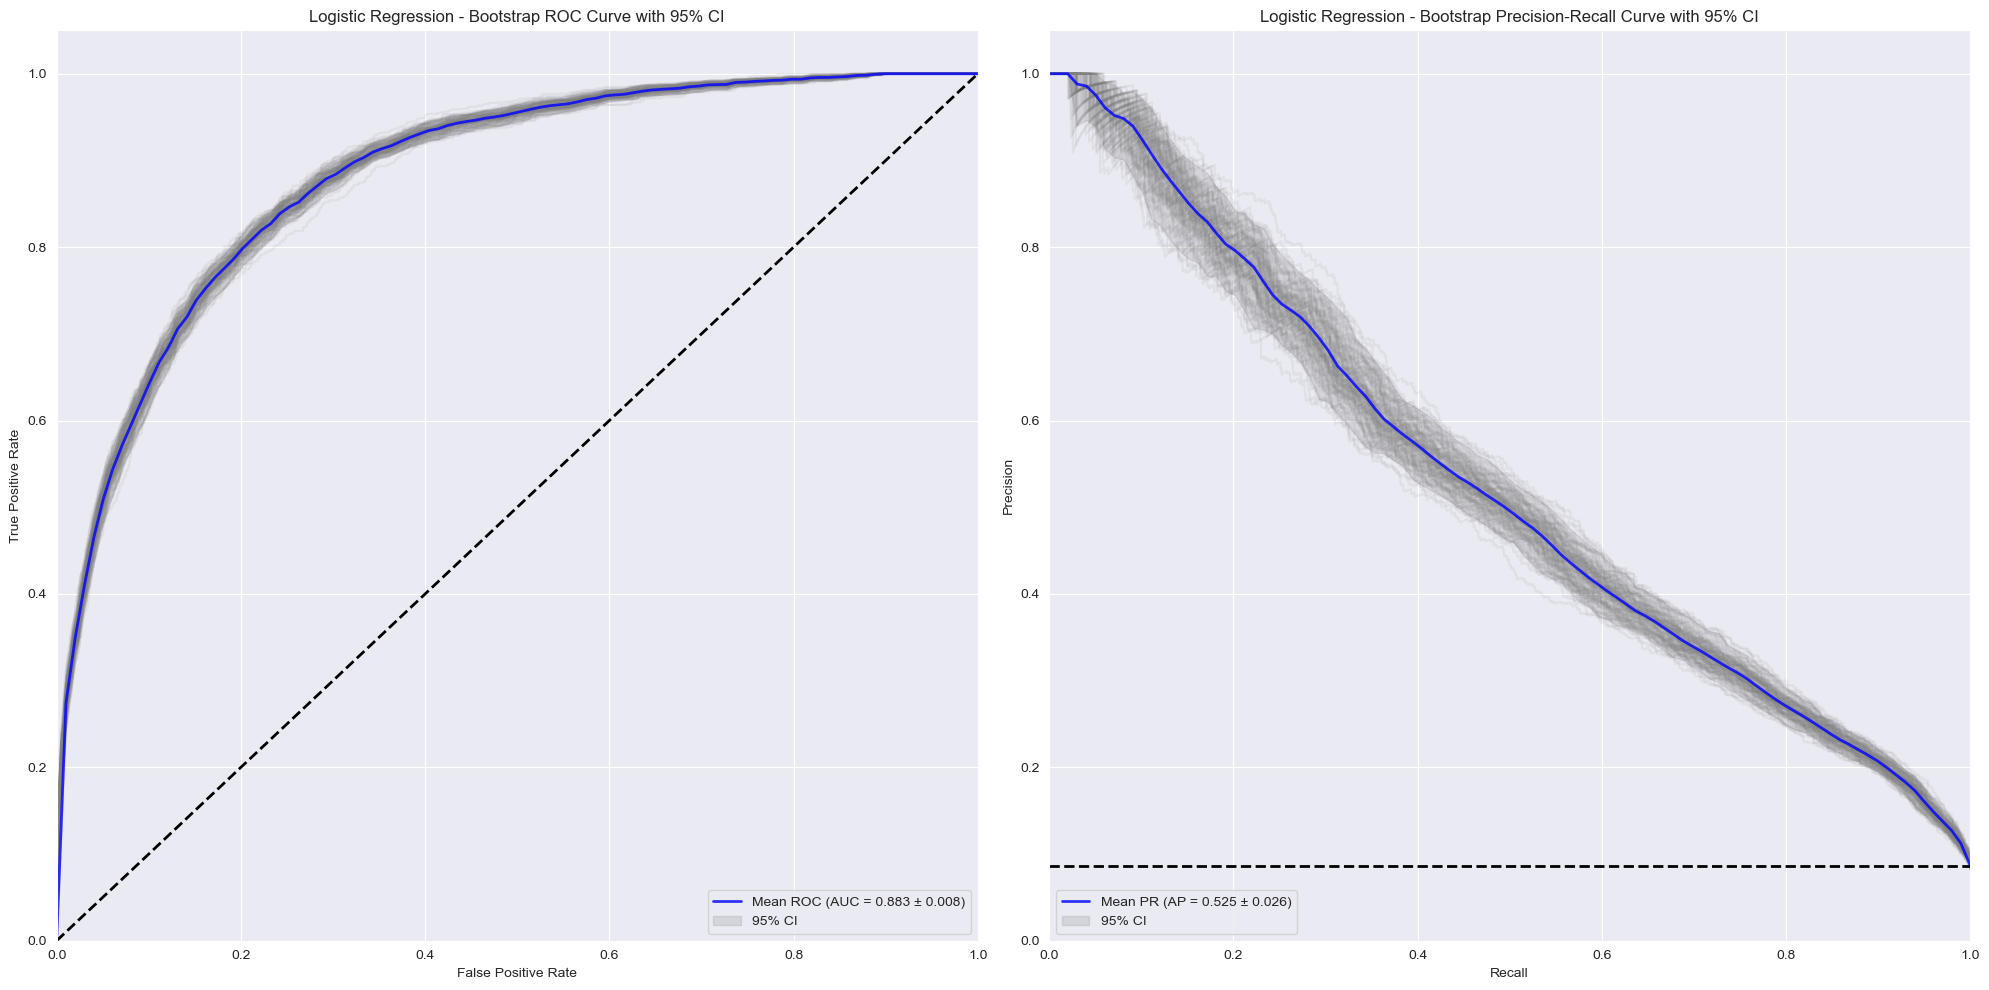


Generating ROC and PR curves for XGBoost...


100%|██████████| 100/100 [00:01<00:00, 99.13it/s]


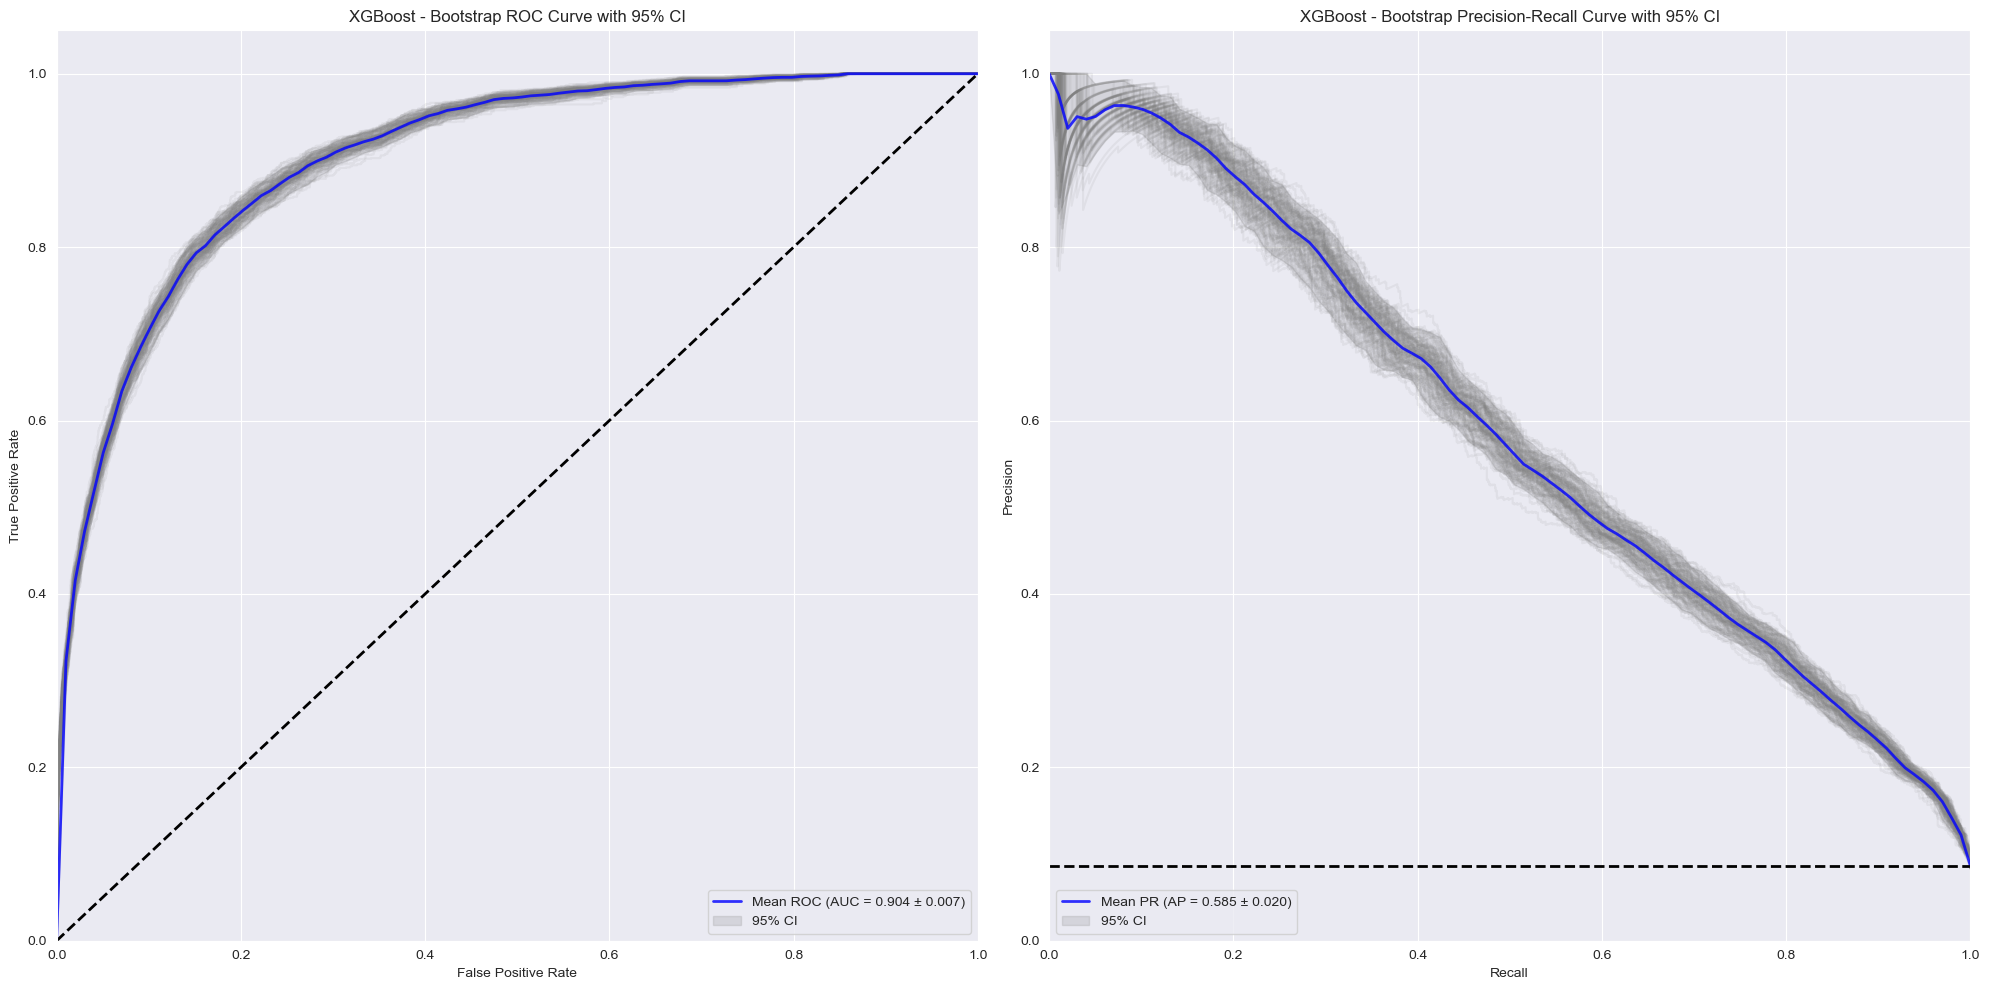


Generating ROC and PR curves for KNN...


100%|██████████| 100/100 [00:00<00:00, 127.89it/s]


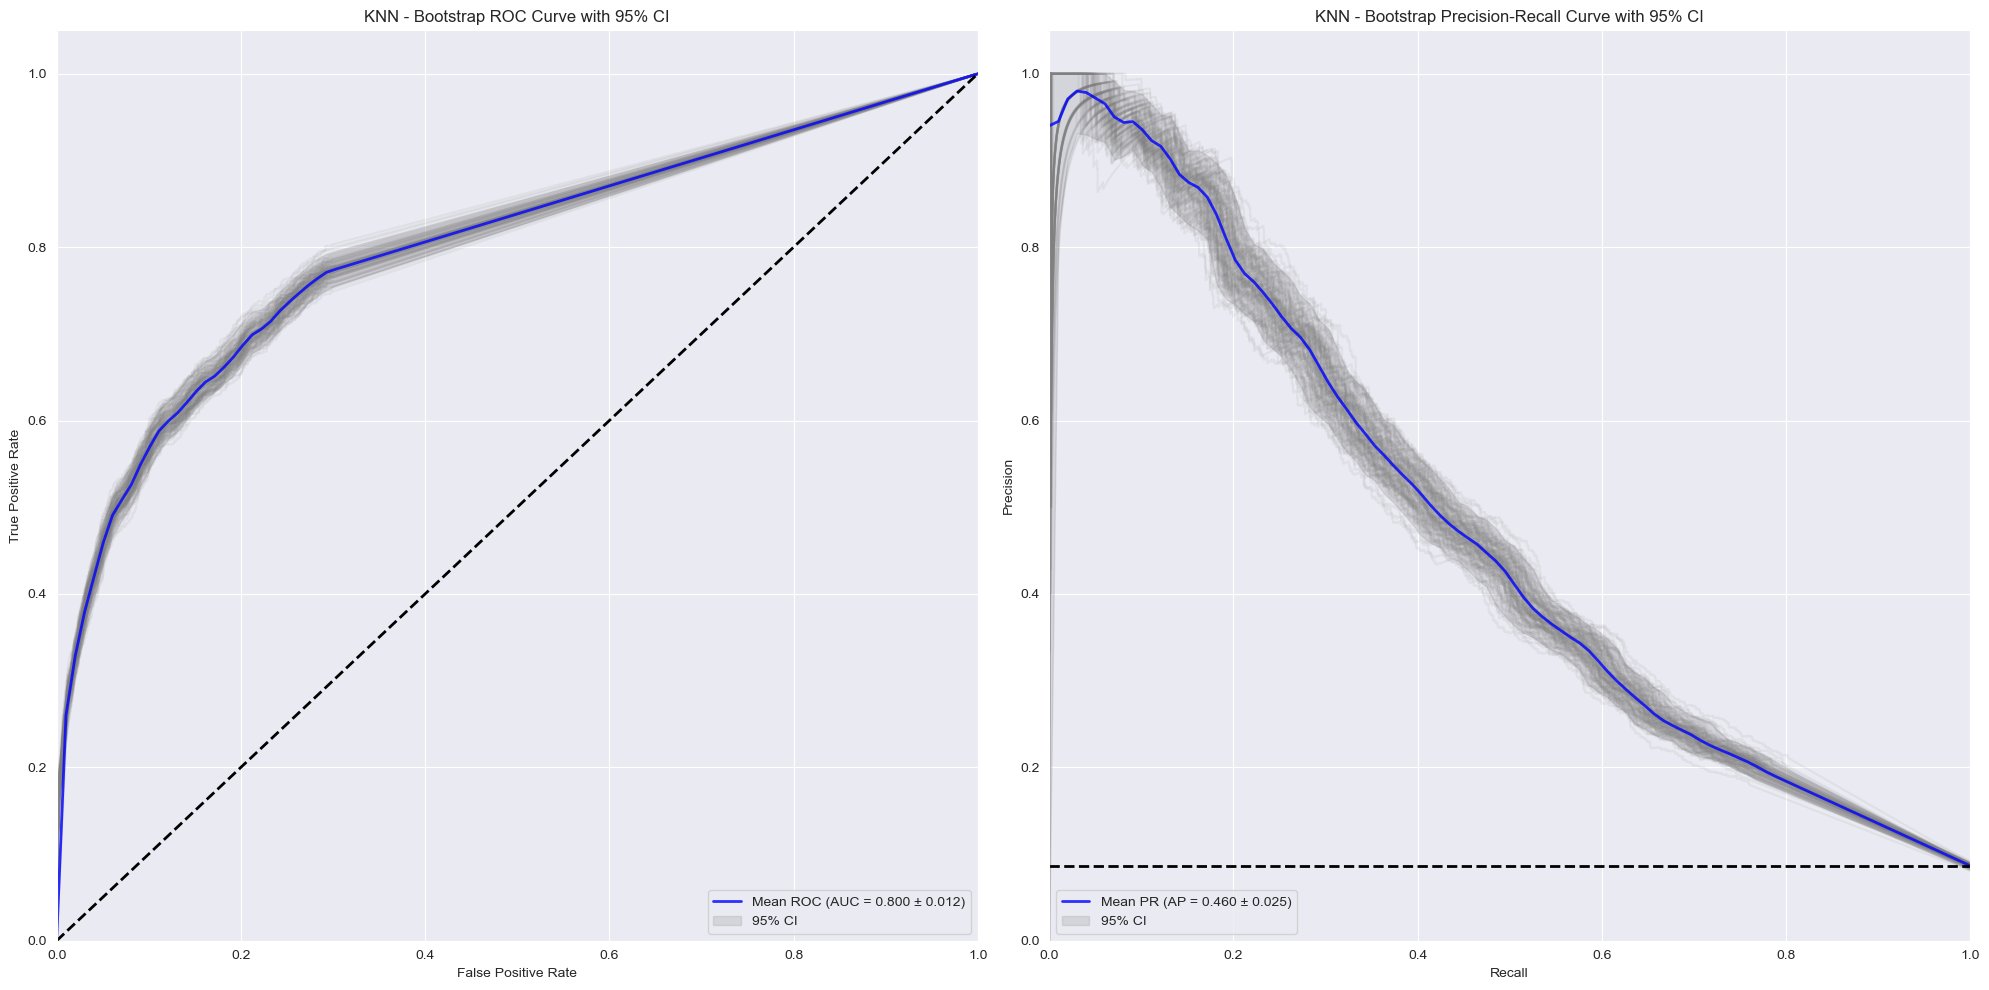

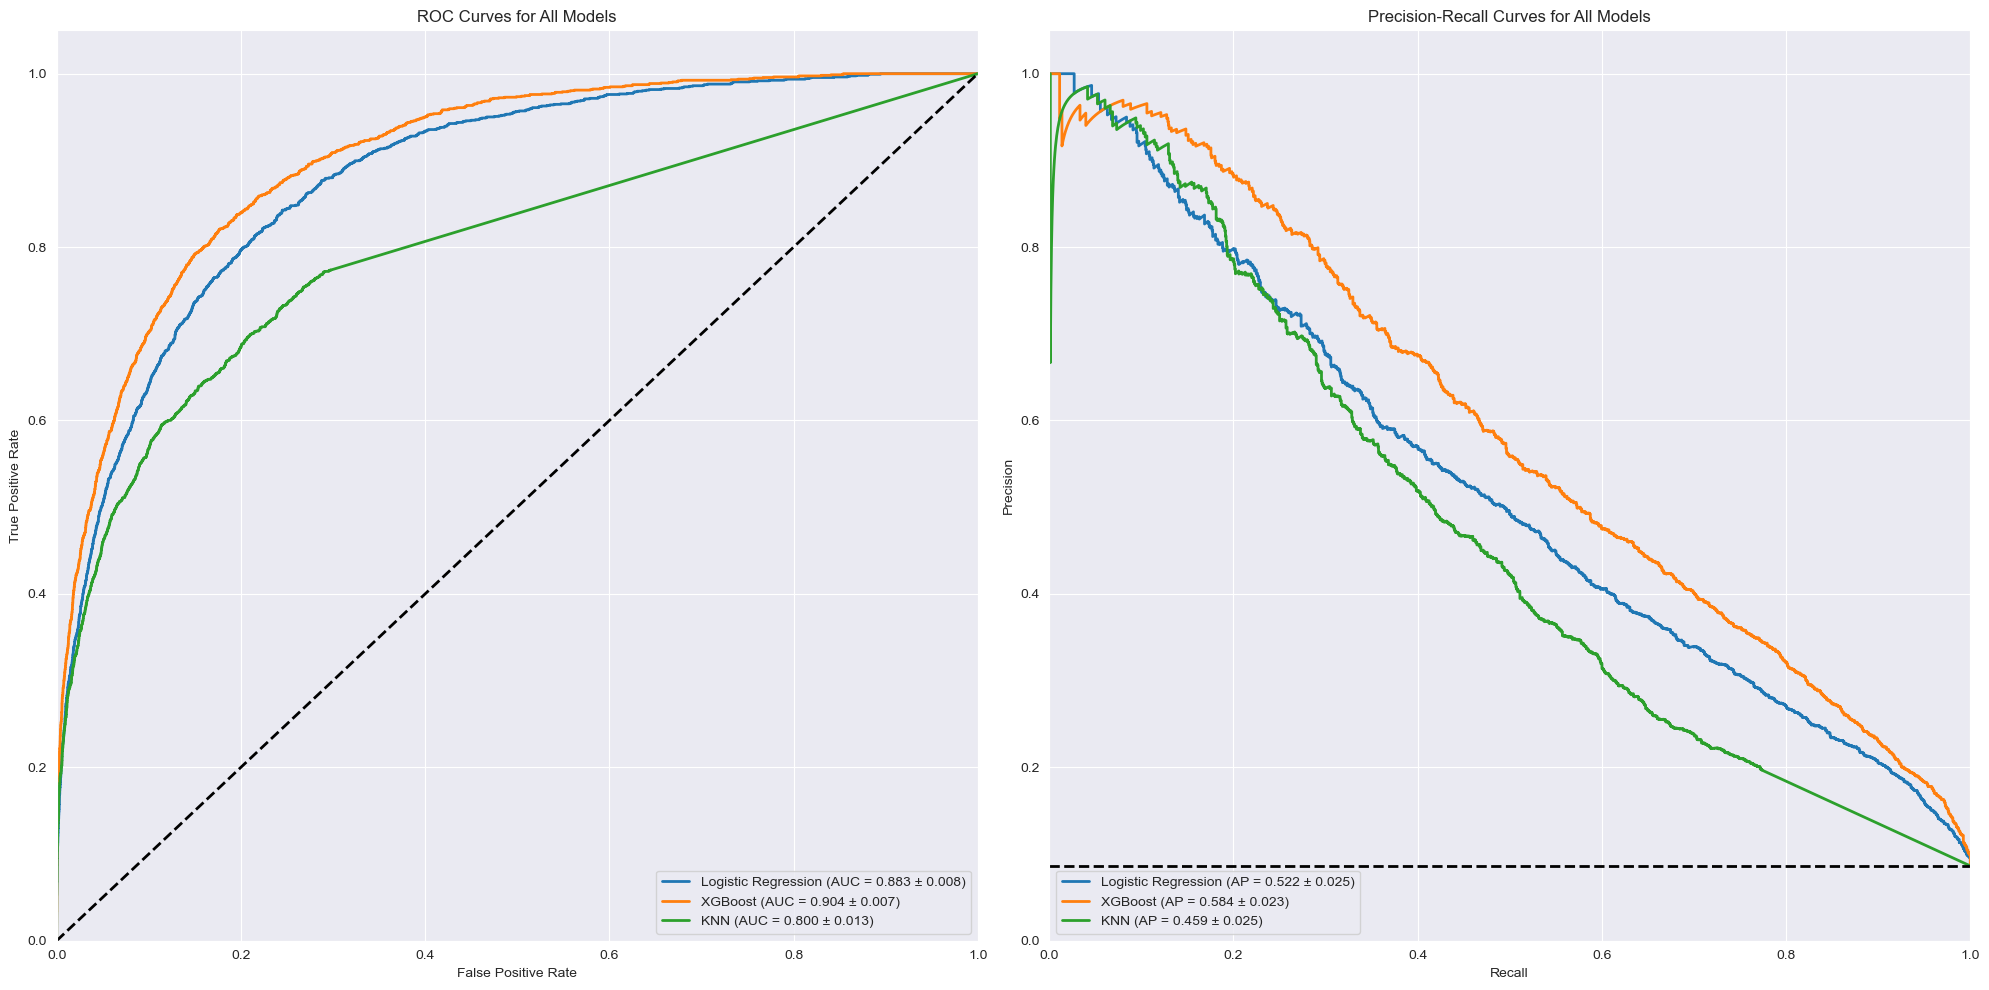

Model Logistic Regression saved to models/logistic_regression_final_model.joblib
Model XGBoost saved to models/xgboost_final_model.joblib
Model KNN saved to models/knn_final_model.joblib
Bootstrap results saved to models/all_models_bootstrap_results.joblib
Comparison table saved to models/model_comparison_with_bootstrap.csv


In [328]:
# 8. Create a detailed comparison table for all models and metrics
comparison_df = pd.DataFrame(index=model_names, columns=[])

for metric in metrics_to_plot:
    for model_name in model_names:
        comparison_df.loc[model_name, f"{metric} Mean"] = bootstrap_results[model_name][metric]['Mean']
        comparison_df.loc[model_name, f"{metric} Margin"] = bootstrap_results[model_name][metric]['Margin']

print("\nDetailed Comparison Table:")
print(comparison_df.round(4))

# 9. Plot ROC and PR curves with bootstrap confidence intervals for each model
for model_name, model in best_models.items():
    print(f"\nGenerating ROC and PR curves for {model_name}...")
    
    # Get predictions
    y_test_prob = model.predict_proba(X_test)[:, 1]
    
    # Initialize bootstrap samples for curves
    bootstrap_tprs = []
    bootstrap_aucs = []
    bootstrap_precisions = []
    bootstrap_pr_aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    mean_recall = np.linspace(0, 1, 100)
    
    # Number of bootstrap samples to plot (for visualization)
    n_plot_bootstraps = 100
    
    plt.figure(figsize=(20, 10))
    
    # Generate bootstrap samples
    for i in tqdm(range(n_plot_bootstraps)):
        indices = np.random.choice(len(y_test), len(y_test), replace=True)
        y_true_bootstrap = y_test.iloc[indices].values if isinstance(y_test, pd.Series) else y_test[indices]
        y_prob_bootstrap = y_test_prob[indices]
        
        # ROC curve
        fpr, tpr, _ = roc_curve(y_true_bootstrap, y_prob_bootstrap)
        bootstrap_tprs.append(np.interp(mean_fpr, fpr, tpr))
        bootstrap_tprs[-1][0] = 0.0
        bootstrap_aucs.append(roc_auc_score(y_true_bootstrap, y_prob_bootstrap))
        
        # PR curve
        precision, recall, _ = precision_recall_curve(y_true_bootstrap, y_prob_bootstrap)
        bootstrap_precisions.append(np.interp(mean_recall, recall[::-1], precision[::-1]))
        bootstrap_pr_aucs.append(average_precision_score(y_true_bootstrap, y_prob_bootstrap))
        
        # Plot light gray lines for individual bootstrap samples
        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr, color='gray', alpha=0.1)
        
        plt.subplot(1, 2, 2)
        plt.plot(recall, precision, color='gray', alpha=0.1)
    
    # ROC Curve with confidence interval
    plt.subplot(1, 2, 1)
    mean_tpr = np.mean(bootstrap_tprs, axis=0)
    mean_auc = np.mean(bootstrap_aucs)
    std_auc = np.std(bootstrap_aucs)
    
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=f'Mean ROC (AUC = {mean_auc:.3f} ± {1.96*std_auc:.3f})',
             lw=2, alpha=0.8)
    
    tpr_upper = np.percentile(bootstrap_tprs, 97.5, axis=0)
    tpr_lower = np.percentile(bootstrap_tprs, 2.5, axis=0)
    plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color='gray', alpha=0.2,
                     label='95% CI')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - Bootstrap ROC Curve with 95% CI')
    plt.legend(loc="lower right")
    
    # PR Curve with confidence interval
    plt.subplot(1, 2, 2)
    mean_precision = np.mean(bootstrap_precisions, axis=0)
    mean_pr_auc = np.mean(bootstrap_pr_aucs)
    std_pr_auc = np.std(bootstrap_pr_aucs)
    
    plt.plot(mean_recall, mean_precision, color='b',
             label=f'Mean PR (AP = {mean_pr_auc:.3f} ± {1.96*std_pr_auc:.3f})',
             lw=2, alpha=0.8)
    
    precision_upper = np.percentile(bootstrap_precisions, 97.5, axis=0)
    precision_lower = np.percentile(bootstrap_precisions, 2.5, axis=0)
    plt.fill_between(mean_recall, precision_lower, precision_upper, color='gray', alpha=0.2,
                     label='95% CI')
    
    # Add baseline (no skill)
    no_skill = np.sum(y_test) / len(y_test)
    plt.plot([0, 1], [no_skill, no_skill], 'k--', lw=2)
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} - Bootstrap Precision-Recall Curve with 95% CI')
    plt.legend(loc="lower left")
    
    plt.tight_layout()
    plt.savefig(f'{model_name.replace(" ", "_").lower()}_bootstrap_curves.png', dpi=300)
    plt.show()

# 10. Plot all models' ROC and PR curves on the same plot for comparison
# ROC Curves
plt.figure(figsize=(20, 10))

# ROC plot
plt.subplot(1, 2, 1)
for model_name, model in best_models.items():
    y_test_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    roc_auc = roc_auc_score(y_test, y_test_prob)
    
    mean_auc = bootstrap_results[model_name]['ROC AUC']['Mean']
    margin = bootstrap_results[model_name]['ROC AUC']['Margin']
    
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {mean_auc:.3f} ± {margin:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc="lower right")

# PR plot
plt.subplot(1, 2, 2)
for model_name, model in best_models.items():
    y_test_prob = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_test_prob)
    pr_auc = average_precision_score(y_test, y_test_prob)
    
    mean_pr_auc = bootstrap_results[model_name]['PR AUC']['Mean']
    margin = bootstrap_results[model_name]['PR AUC']['Margin']
    
    plt.plot(recall, precision, lw=2, label=f'{model_name} (AP = {mean_pr_auc:.3f} ± {margin:.3f})')

# Add baseline (no skill)
no_skill = np.sum(y_test) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for All Models')
plt.legend(loc="lower left")

plt.tight_layout()
plt.savefig('all_models_curves_comparison.png', dpi=300)
plt.show()

# 11. Save all models and results
for model_name, model in best_models.items():
    model_filename = f"models/{model_name.replace(' ', '_').lower()}_final_model.joblib"
    joblib.dump(model, model_filename)
    print(f"Model {model_name} saved to {model_filename}")

# Save the bootstrap results
joblib.dump(bootstrap_results, "models/all_models_bootstrap_results.joblib")
print("Bootstrap results saved to models/all_models_bootstrap_results.joblib")

# Export the comparison table to CSV
comparison_df.to_csv("models/model_comparison_with_bootstrap.csv")
print("Comparison table saved to models/model_comparison_with_bootstrap.csv")

In [317]:
# 10. Save the final best model
model_filename = f"models/{best_model_name.replace(' ', '_').lower()}_final_model.joblib"
joblib.dump(best_model, model_filename)
print(f"\nFinal model saved to {model_filename}")›

# Also save the bootstrap results for future reference
joblib.dump(bootstrap_results, "models/bootstrap_results.joblib")
print("Bootstrap results saved to models/bootstrap_results.joblib")


Final model saved to models/xgboost_final_model.joblib
Bootstrap results saved to models/bootstrap_results.joblib


## Local Shap Analysis

In [300]:
# List of model files
MODELS_DIR = 'models'
model_files = [f for f in os.listdir(MODELS_DIR) if f.endswith('_best_model.joblib')]
print(f"Found {len(model_files)} model files: {model_files}")

# Check if model file exists that contains all models
all_models_path = os.path.join(MODELS_DIR, 'all_best_models.joblib')
if os.path.exists(all_models_path):
    print("Loading all models from combined file...")
    models_dict = joblib.load(all_models_path)
    if isinstance(models_dict, dict):
        print(f"Models in all_best_models.joblib: {list(models_dict.keys())}")
    else:
        print("all_best_models.joblib does not contain a dictionary of models")
        models_dict = None
else:
    models_dict = None


Found 3 model files: ['xgboost_best_model.joblib', 'knn_best_model.joblib', 'logistic_regression_best_model.joblib']
Loading all models from combined file...
Models in all_best_models.joblib: ['Logistic Regression', 'XGBoost', 'KNN']


In [302]:
# Function to get SHAP values
def get_shap_values(model, X, model_type):
    print(f"Calculating SHAP values for {model_type}...")
    
    # For a single test instance (for demonstration)
    if len(X) > 1:
        sample_idx = 0  # Choose the first sample
        X_sample = X.iloc[[sample_idx]]
        print(f"Using sample at index {sample_idx} for SHAP explanation")
    else:
        X_sample = X
    
    try:
        if model_type == 'xgboost':
            explainer = shap.Explainer(model)
            shap_values = explainer(X_sample)
        elif model_type in ['knn', 'logistic_regression']:
            # For non-tree models, use KernelExplainer
            # Create a background dataset for KernelExplainer
            # Using a small subset of training data as background
            background = X.iloc[:min(100, len(X))]  # Use up to 100 samples as background
            explainer = shap.KernelExplainer(model.predict_proba, background)
            shap_values = explainer.shap_values(X_sample)
            # Take the positive class (assuming binary classification)
            if isinstance(shap_values, list) and len(shap_values) > 1:
                shap_values = shap_values[1]
        else:
            # General approach for other models
            explainer = shap.Explainer(model, X.iloc[:min(100, len(X))])
            shap_values = explainer(X_sample)
            
        return shap_values, X_sample
    except Exception as e:
        print(f"Error getting SHAP values for {model_type}: {e}")
        return None, X_sample


In [303]:
# Create a directory for saving SHAP plots
BASE_DIR = '/Users/ormeiri/Desktop/predictive_models_git'
output_dir = os.path.join(BASE_DIR, 'shap_output')
os.makedirs(output_dir, exist_ok=True)

In [305]:
# Process individual models
for model_file in model_files:
    model_path = os.path.join(MODELS_DIR, model_file)
    model_type = model_file.split('_best_model.joblib')[0]
    
    print(f"\nProcessing {model_type} model...")
    model = joblib.load(model_path)
    
    # Get SHAP values
    shap_values, X_sample = get_shap_values(model, X_test, model_type)
    
    if shap_values is not None:
        # Create and save SHAP plot
        plt.figure(figsize=(12, 8))
        if hasattr(shap_values, 'values'):
            # For new-style SHAP values (Tree explainers)
            shap.plots.waterfall(shap_values[0], max_display=15, show=False)
        else:
            # For old-style SHAP values (Kernel explainer)
            shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
        
        plot_path = os.path.join(output_dir, f'shap_values_{model_type}.png')
        plt.tight_layout()
        plt.savefig(plot_path)
        plt.close()
        print(f"SHAP plot saved to {plot_path}")
        
        # Export SHAP values to CSV
        if hasattr(shap_values, 'values'):
            # For new-style SHAP objects
            shap_df = pd.DataFrame({
                'Feature': X_sample.columns,
                'SHAP Value': shap_values.values[0]
            })
        else:
            # For old-style SHAP values
            shap_df = pd.DataFrame({
                'Feature': X_sample.columns,
                'SHAP Value': shap_values[0]
            })
        
        shap_df = shap_df.sort_values('SHAP Value', key=abs, ascending=False)
        csv_path = os.path.join(output_dir, f'shap_values_{model_type}.csv')
        shap_df.to_csv(csv_path, index=False)
        print(f"SHAP values exported to {csv_path}")



Processing xgboost model...
Calculating SHAP values for xgboost...
Using sample at index 0 for SHAP explanation
SHAP plot saved to /Users/ormeiri/Desktop/predictive_models_git/shap_output/shap_values_xgboost.png
SHAP values exported to /Users/ormeiri/Desktop/predictive_models_git/shap_output/shap_values_xgboost.csv

Processing knn model...
Calculating SHAP values for knn...
Using sample at index 0 for SHAP explanation


  0%|          | 0/1 [00:00<?, ?it/s]

SHAP plot saved to /Users/ormeiri/Desktop/predictive_models_git/shap_output/shap_values_knn.png


/Users/ormeiri/anaconda3/lib/python3.11/site-packages/shap/plots/_beeswarm.py:950: UserWarning: The figure layout has changed to tight
  pl.tight_layout()
/Users/ormeiri/anaconda3/lib/python3.11/site-packages/shap/plots/_beeswarm.py:624: UserWarning: The figure layout has changed to tight
  pl.tight_layout(pad=0, w_pad=0, h_pad=0.0)
/var/folders/68/dmpmrx5n0ts80f_y59l1n8y00000gn/T/ipykernel_11322/3146763015.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


ValueError: Per-column arrays must each be 1-dimensional

<Figure size 1200x800 with 0 Axes>

In [306]:
# Process models from all_best_models.joblib if available
if models_dict is not None:
    for model_name, model in models_dict.items():
        print(f"\nProcessing {model_name} model from all_best_models.joblib...")
        
        # Get SHAP values
        shap_values, X_sample = get_shap_values(model, X_test, model_name)
        
        if shap_values is not None:
            # Create and save SHAP plot
            plt.figure(figsize=(12, 8))
            if hasattr(shap_values, 'values'):
                # For new-style SHAP values
                shap.plots.waterfall(shap_values[0], max_display=15, show=False)
            else:
                # For old-style SHAP values
                shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
            
            plot_path = os.path.join(output_dir, f'shap_values_{model_name}.png')
            plt.tight_layout()
            plt.savefig(plot_path)
            plt.close()
            print(f"SHAP plot saved to {plot_path}")
            
            # Export SHAP values to CSV
            if hasattr(shap_values, 'values'):
                # For new-style SHAP objects
                shap_df = pd.DataFrame({
                    'Feature': X_sample.columns,
                    'SHAP Value': shap_values.values[0]
                })
            else:
                # For old-style SHAP values
                shap_df = pd.DataFrame({
                    'Feature': X_sample.columns,
                    'SHAP Value': shap_values[0]
                })
            
            shap_df = shap_df.sort_values('SHAP Value', key=abs, ascending=False)
            csv_path = os.path.join(output_dir, f'shap_values_{model_name}.csv')
            shap_df.to_csv(csv_path, index=False)
            print(f"SHAP values exported to {csv_path}")

print("\nDone! SHAP values have been generated for all models.")


Processing Logistic Regression model from all_best_models.joblib...
Calculating SHAP values for Logistic Regression...
Using sample at index 0 for SHAP explanation
SHAP plot saved to /Users/ormeiri/Desktop/predictive_models_git/shap_output/shap_values_Logistic Regression.png
SHAP values exported to /Users/ormeiri/Desktop/predictive_models_git/shap_output/shap_values_Logistic Regression.csv

Processing XGBoost model from all_best_models.joblib...
Calculating SHAP values for XGBoost...
Using sample at index 0 for SHAP explanation
Error getting SHAP values for XGBoost: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

Processing KNN model from all_best_models.joblib...
Calculating SHAP values for KNN...
Using sample at index 0 for SHAP explanation
Error getting SHAP values for KNN: The passed model is not callable and cannot be analyzed directly with the given masker! Model: KNeighborsClassifier(n_neighbors=21, p=1, weights='distance')

Done! SHAP v

Found a NULL input array in _cext_dense_tree_update_weights!
